In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [ ]:
import sys
sys.executable


'/home/dung/homework1/AA174a-HW1/.venv/bin/python'

## Dynamics Base Class

In [3]:
class Dynamics():

  def __init__(self):
    super().__init__()
    self.dt = 0.01
    self.noisy = True

  def feed_forward(self, state, control):
    raise NotImplementedError("Calling abstract function")

  def rollout(self, state_init, control_traj, num_rollouts):
    raise NotImplementedError("Calling abstract function")


## TurtleBot Example

In [4]:
class TurtleBotState():
  def __init__(self, x=0, y=0, th=0):
    self.x  = x
    self.y  = y
    self.th = th

In [5]:
class TurtleBotControl():
  def __init__(self, v=0, o=0):
    self.v = v
    self.o = o

In [6]:
class TurtleBotDynamics(Dynamics):

  def __init__(self) -> None:
    super().__init__()
    self.n = 3  # length of state
    self.m = 2  # length of control

  def feed_forward(self, state, control):
    # Gaussian noise
    if not self.noisy:
        var = np.zeros(3)
    else:
        var = np.array([0.01, 0.01, 0.001])

    w = np.random.normal(0.0, var)

    x, y, th = state
    v, omega = control

    state_new = np.zeros(3)
    state_new[0] = x  + self.dt * v * np.cos(th)
    state_new[1] = y  + self.dt * v * np.sin(th)
    state_new[2] = th + self.dt * omega

    return state_new + w


  def rollout(self, state_init, control_traj, num_rollouts):
    num_steps = control_traj.shape[1]

    state_traj_rollouts = np.zeros((self.n*num_rollouts, num_steps+1))
    ############################## Code starts here ##############################
    """
    Use two for-loops to loop through "num_rollouts" and "num_steps" to populate "state_traj_rollouts". Use the "feed_forward" function above.
    """
    for i in range(num_rollouts):
      x = np.array([state_init.x, state_init.y, state_init.th])
      row_start = i * self.n
      row_end   = (i + 1) * self.n

      state_traj_rollouts[row_start:row_end, 0] = x

      for t in range(num_steps):
          u_t = control_traj[:, t]
          x = self.feed_forward(x, u_t)
          state_traj_rollouts[row_start:row_end, t+1] = x

      

    ############################## Code ends here ##############################

    return state_traj_rollouts

In [7]:
# Run Turtlebot Dynamics Rollouts

# Constants
num_rollouts = 10
num_steps = 100

# Define the dynamics class
tb_dynamics = TurtleBotDynamics()

# Define the control inputs
control_traj = np.ones((tb_dynamics.m,num_steps))
control_traj[1,:] = np.sin(np.linspace(0.0, 2*np.pi, num_steps))

# Define inital state
state_init = TurtleBotState(0.0, 0.0, 0.0)

# Rollouts dynamics
state_traj_rollouts = tb_dynamics.rollout(state_init, control_traj, num_rollouts)

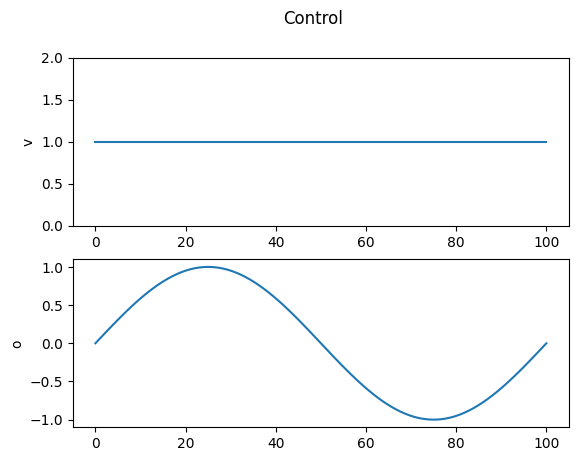

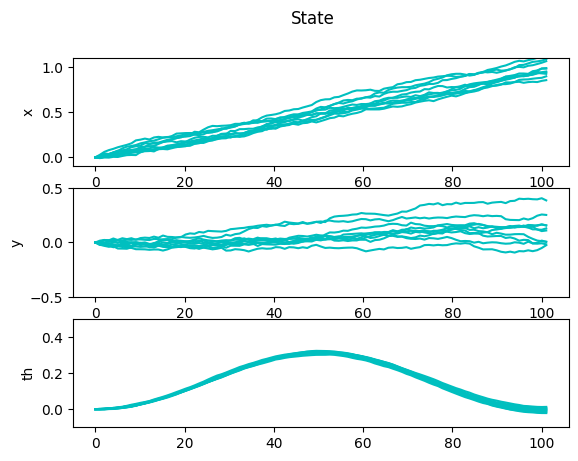

In [8]:
# Plot control inputs
fig_ctrl, axs_ctrl = plt.subplots(nrows=tb_dynamics.m)
ylabels_ctrl = ["v", "o"]
ylims_ctrl = np.array([[0.0, 2.0],[-1.1, 1.1]])
for j in range(tb_dynamics.m):
  axs_ctrl[j].plot(np.linspace(0,num_steps,num_steps), control_traj[j, :])
  axs_ctrl[j].set_ylabel(ylabels_ctrl[j])
  axs_ctrl[j].set_ylim(ylims_ctrl[j,:])
fig_ctrl.suptitle("Control")

# Plot state trajectory rollouts
fig_state, axs_state = plt.subplots(nrows=tb_dynamics.n)
ylabels_state = ["x", "y", "th"]
ylims_state = np.array([[-0.1, 1.1], [-0.5, 0.5], [-0.1, 0.5]])
for i in range(num_rollouts):
  for j in range(tb_dynamics.n):
    axs_state[j].plot(np.linspace(0,num_steps+1,num_steps+1), state_traj_rollouts[tb_dynamics.n*i + j, :], c='c')
    axs_state[j].set_ylabel(ylabels_state[j])
    axs_state[j].set_ylim(ylims_state[j,:])
fig_state.suptitle("State")
plt.show()

## Double Integrator Example

In [10]:
class DoubleIntegratorDynamics(Dynamics):

  def __init__(self) -> None:
    super().__init__()
    self.xdd_max = 0.5 # m/s^2
    self.ydd_max = 0.5 # m/s^2
    self.n = 4
    self.m = 2

  def feed_forward(self, state:np.array, control:np.array):

    num_rollouts = int(state.shape[0] / self.n)

    # Define Gaussian Noise
    if self.noisy == False:
      var = np.array([0.0, 0.0, 0.0, 0.0])
    else:
      var = np.array([0.01, 0.01, 0.001, 0.001])

    var_stack = np.tile(var, num_rollouts)
    w = np.random.normal(loc=np.zeros(state.shape), scale=var_stack)

    # State space dynamics (single rollout)
    A = np.array([[1.0, 0.0, self.dt, 0.0],
                  [0.0, 1.0, 0.0, self.dt],
                  [0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 1.0]])

    B = np.array([[0.0, 0.0],
                  [0.0, 0.0],
                  [self.dt, 0.0],
                  [0.0, self.dt]])

    # Stack dynamics
    A_stack = np.kron(np.eye(num_rollouts), A)
    B_stack = np.tile(B, (num_rollouts, 1))

    # Vectorized update
    state_new = A_stack @ state + B_stack @ control

    # Add noise
    state_new = state_new + w

    return state_new

  def rollout(self, state_init, control_traj, num_rollouts):

    num_steps = control_traj.shape[1]

    state_traj = np.zeros((self.n*num_rollouts, num_steps+1))
    state_traj[:,0] = np.tile(state_init, num_rollouts)

    for t in range(num_steps):
      state_traj[:, t+1] = self.feed_forward(
          state_traj[:, t],
          control_traj[:, t]
      )

    return state_traj


In [11]:
# Run Double Integrator Dynamics Rollouts

# Constants
num_rollouts = 10
num_steps = 100

# Define the dynamics class
di_dynamics = DoubleIntegratorDynamics()

# Define the control inputs
control_traj = np.zeros((di_dynamics.m,num_steps))
control_traj[0,:] = np.sin(np.linspace(0.0, 2*np.pi, num_steps))
control_traj[1,:] = np.cos(np.linspace(0.0, 2*np.pi, num_steps))

# Define the initial state
state_init = np.array([0.0, 0.0, 0.0, 0.0])

# Rollouts dynamics
state_traj_rollouts = di_dynamics.rollout(state_init, control_traj, num_rollouts)

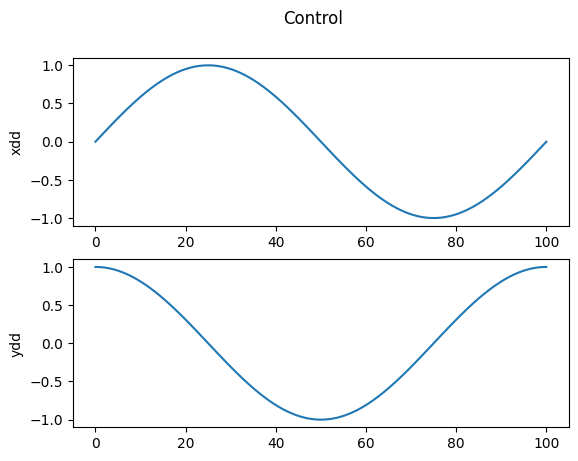

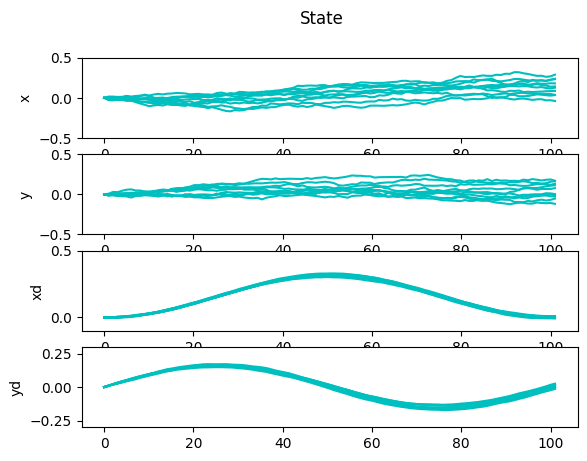

In [12]:
# Plot control inputs
fig_ctrl, axs_ctrl = plt.subplots(nrows=di_dynamics.m)
ylabels_ctrl = ["xdd", "ydd"]
ylims_ctrl = np.array([[-1.1, 1.1],[-1.1, 1.1]])
for j in range(di_dynamics.m):
  axs_ctrl[j].plot(np.linspace(0,num_steps,num_steps), control_traj[j, :])
  axs_ctrl[j].set_ylabel(ylabels_ctrl[j])
  axs_ctrl[j].set_ylim(ylims_ctrl[j,:])
fig_ctrl.suptitle("Control")

# Plots state trajectory rollouts
fig_state, axs_state = plt.subplots(nrows=di_dynamics.n)
ylabels_state = ["x", "y", "xd", "yd"]
ylims_state = np.array([[-0.5, 0.5], [-0.5, 0.5], [-0.1, 0.5], [-0.3, 0.3]])
for i in range(num_rollouts):
  for j in range(di_dynamics.n):
    axs_state[j].plot(np.linspace(0,num_steps+1,num_steps+1), state_traj_rollouts[di_dynamics.n*i + j, :], c='c')
    axs_state[j].set_ylabel(ylabels_state[j])
    axs_state[j].set_ylim(ylims_state[j,:])
fig_state.suptitle("State")
plt.show()